# Modello finale

In [8]:
from analysis import MatchAnalysis #per il file con le medie
import util_strings as utils

In [9]:
import pickle
vectorizer = pickle.load(open(utils.vectorizer, 'rb'))
football_prediction = pickle.load(open(utils.classificator_FP, 'rb'))

Qui devo: 
* caricare il modello di football prediction, ottenere le etichette ed usarle nel dataset finale
* convertire ciascuna etichetta in 0 1 2 (verificare che non ci siano dati vuoti)
* allenare il modello su tutti i dati

In [10]:
import pandas as pd
import json
completed = pd.read_csv(utils.completed_dataset, index_col=0)

with open(utils.teams_codes, 'rb') as json_file:
    id_set = json.load(json_file)

#prendo il valore dell'ultimo id, in modo tale da assegnarlo alla prossima squadra
cont = 0
for team, id in id_set.items():
    if id == cont:
        cont+=1

import numpy as np
teams = np.append(completed.home.unique(), completed.away.unique())
teams = np.unique(teams)

In [11]:
keys = id_set.keys()
for team in teams:
    if team.lower() not in keys:
        id_set[team.lower()]=cont
        cont+=1

In [12]:
from my_tokenizer import MyTokenizer
mt = MyTokenizer(completed)
mt.clean_text()
vectorized = vectorizer.transform(mt.cleaned_corpus)

In [13]:
labels = football_prediction.predict(vectorized)

Ora queste etichette le metto nel dataset completo

In [17]:
completed = completed[completed.prediction != 'NAN']
final_dataset = completed.copy()
index = 0

dict_result = {'N': 0, 'V': 1, 'P': 2}
for i, row in completed.iterrows():
    final_dataset.at[i, 'prediction'] = labels[index]
    final_dataset.at[i, 'result'] = dict_result[row.result]
    final_dataset.at[i, 'home'] = id_set[row.home]
    final_dataset.at[i, 'away'] = id_set[row.away]
    index += 1

KeyError: 2.0

Ora che ho ottenuto le etichette, i valori nulli li sostituisco con -1, se no perdo le partite

In [ ]:
final_dataset['home'] = final_dataset['home'].astype(float)
final_dataset['away'] = final_dataset['away'].astype(float)
final_dataset['prediction'] = final_dataset['prediction'].astype(float)
final_dataset['result'] = final_dataset['result'].astype(float)

final_dataset = final_dataset[final_dataset.prediction != 'NAN']

Ora che ho ottenuto il dataset come deve essere ottenuto, posso fare la classificazione secondo Decision Tree o Random Forest

Normalizzazione dei dati

In [ ]:
from sklearn import preprocessing

final_dataset.drop(columns=['description', 'date', 'season'], inplace=True)
final_dataset

,home,result,goals,away,total_shots,shots_on_target,goals_on_penalty,total_penalties,percentage_possession,fouls,yellow_cards,red_cards,rank_h,rank_a,prediction
0,9.0,2.0,-2.4,19.0,-7.2,-2.2,-0.2,0.0,-6.8,4.6,0.0,0.2,1.0,2.0,2.0
1,20.0,2.0,0.8,14.0,-2.0,-0.2,0.2,0.2,-14.6,1.6,0.0,0.2,0.0,5.0,2.0
2,27.0,1.0,0.8,25.0,1.2,2.4,0.2,0.4,2.2,2.4,-1.0,-0.6,3.0,0.0,0.0
3,4.0,2.0,-1.0,3.0,5.0,3.0,-1.0,-1.0,18.0,-2.0,0.0,0.0,6.0,0.0,1.0
4,21.0,0.0,0.8,11.0,4.6,2.6,-0.2,-0.4,5.2,-3.6,0.2,-0.2,4.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,19.0,1.0,1.4,2.0,5.2,3.2,0.4,0.4,6.2,-2.6,-0.6,0.0,9.0,2.0,1.0
1236,15.0,0.0,0.2,28.0,-4.4,0.0,0.2,0.4,-5.4,-5.0,-1.2,0.0,8.0,1.0,2.0
1237,26.0,0.0,0.2,6.0,-1.4,-0.2,-0.2,-0.2,3.6,-0.6,0.8,0.0,4.0,0.0,1.0
1238,24.0,2.0,-0.4,21.0,-5.6,-0.6,-0.2,-0.4,-2.8,3.6,1.8,0.0,3.0,6.0,0.0


In [ ]:
final_dataset.to_csv(utils.final_dataset)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

model = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(final_dataset[[x for x in final_dataset.columns if x != 'result']], final_dataset['result'], test_size=0.2, shuffle=False) 

In [ ]:
import sklearn.metrics as mtr

accuracy = 0

while(accuracy < 0.536):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    analysis = pd.DataFrame()
            
    report = mtr.classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    if accuracy < report['accuracy']:
        accuracy = report['accuracy']
        print(accuracy)

analysis = {
        'Model': 'DecisionTree', 'Accuracy': report['accuracy'],
        'Avg Precision (macro)': report['macro avg']['precision'],
        'Avg Recall (macro)': report['macro avg']['recall'],
        'Avg F1-score (macro)': report['macro avg']['f1-score'],
        'Avg Precision (weighted)': report['weighted avg']['precision'],
        'Avg Recall (weighted)': report['weighted avg']['recall'],
        'Avg F1-score (weighted)': report['weighted avg']['f1-score']
    }

0.5040650406504065
0.5121951219512195
0.516260162601626
0.5203252032520326
0.524390243902439
0.532520325203252
0.5365853658536586


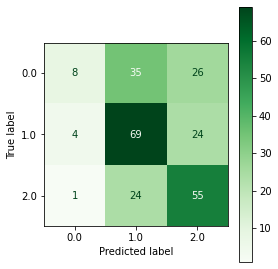

In [ ]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

cm = mtr.confusion_matrix(y_test, y_pred)
d = mtr.ConfusionMatrixDisplay(cm, model.classes_)
fig, ax = plt.subplots(figsize=(4,4))
d.plot(ax=ax, cmap='Greens')
plt.tight_layout()
plt.show()

In [ ]:
import pickle

with open(utils.classificator, 'wb') as file:
    pickle.dump(model, file)